In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image, make_grid

from torchviz import make_dot

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import glob
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import imageio

import enum

In [2]:
torch.cuda.is_available()
device = torch.device("cuda")

In [3]:
#hyperparams & options

EPOCHS = 10
lrD = 0.0002
lrG = 0.0002
bs = 1  #https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/27#issuecomment-346495489
loss_fn = nn.BCELoss().to(device)
loss_fn_img = nn.L1Loss().to(device)
LAMBDA = 100

labelSmoothingFactor = 0.08
flip_labels = True
training_set_size = 865 - 15

CheckpointPeriod = 1 #save the model every <CheckpointPeriod> epochs



In [4]:
class Dsk(nn.Module):
    
    def __init__(self, d=64):
        super(Dsk, self).__init__()
        
        self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)

        return torch.sigmoid(x)
    
    

In [5]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        
           
        #reduce to features
        self.c0 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
      
        
        #upsample to image
        
        self.d3 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.d2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)
        self.d1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.d0 = nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1)
       
        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)
        

      
        self.bnd3 = nn.BatchNorm2d(256)
        self.bnd2 = nn.BatchNorm2d(128)
        self.bnd1 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):           
                
        en0 = self.c0(x)
        en1 = self.bnc1(self.c1(F.leaky_relu(en0, negative_slope=0.2)))
        en2 = self.bnc2(self.c2(F.leaky_relu(en1, negative_slope=0.2)))
        en3 = self.bnc3(self.c3(F.leaky_relu(en2, negative_slope=0.2)))
        
        de3 = self.bnd3(self.d3(F.relu(en3)))
        de2 = F.dropout(self.bnd2(self.d2(F.relu(torch.cat((en2, de3),1)))))
        de1 = self.bnd1(self.d1(F.relu(torch.cat((en1, de2),1))))

        de0 = torch.tanh(self.d0(F.relu(torch.cat((en0, de1),1))))

        return de0


In [6]:
D = Dsk().to(device)
optimizerD = optim.Adam(D.parameters(), lr=lrD)

In [7]:
G = Generator(1,1).to(device)
optimizerG = optim.Adam(G.parameters(), lr=lrG)

In [8]:
torch.flatten(D(torch.ones(1,2,32,128).cuda().detach())).shape

torch.Size([28])

In [9]:
#LOAD STATE DICTs IF CONTINUING TRAINING

'''

G.load_state_dict(torch.load('G15.pth'))
D.load_state_dict(torch.load('D15.pth'))
G.eval()
D.eval()

'''

"\n\nG.load_state_dict(torch.load('G15.pth'))\nD.load_state_dict(torch.load('D15.pth'))\nG.eval()\nD.eval()\n\n"

In [10]:
data = torch.tensor(np.load('cdac_data.npy')).float().to(device)
print(len(data))
#data is (N, outchannels + inchannels, height, width)

865


In [11]:
trainData = data[:training_set_size]
testData = data[training_set_size:]
testData.shape
trainData[:,0,:,:].unsqueeze(1).shape

torch.Size([850, 1, 32, 128])

In [12]:

if(flip_labels):    
    zeroLabel = torch.zeros(bs*28).to(device) + labelSmoothingFactor
    oneLabel = torch.ones(bs*28).to(device) - labelSmoothingFactor
else:
    zeroLabel = torch.ones(bs*28).to(device) - labelSmoothingFactor
    oneLabel = torch.zeros(bs*28).to(device) + labelSmoothingFactor


with open("pix2pixPlateGenLog.log", "w") as logfile:
    
    #creating image folder
    try:
        os.mkdir('./generated_images/')
    
    except Exception as e:
        print('Mkdir failed. %s. Reason: %s' % ('./generated_images/', e))
    
    
    #clearing image folder
    files = glob.glob('./generated_images/*')
    for file in files:
        os.remove(file)
        
    #creating models folder
    try:
        os.mkdir('./epochModelParamData/')
    
    except Exception as e:
        print('Mkdir failed. %s. Reason: %s' % ('./epochModelParamData/', e))
    
    #clearing models folder
    files = glob.glob('./epochModelParamData/*')
    for file in files:
        os.remove(file)
        
    

    #logfile csv header
    logfile.write(f"time,D_loss_real,D_loss_fake,G_loss,epoch\n")
    
    for epoch in tqdm(range(EPOCHS)):
             
        for i in tqdm(range(0, training_set_size, bs)):

            batchOfRealPairs = trainData[i:i+bs]           #(bs, 2, 32, 128)
            batchOfRealImgs = batchOfRealPairs[:,0,:,:].unsqueeze(1)   #(bs, 1, 32, 128)
            batchOfOutlines = batchOfRealPairs[:,1,:,:].unsqueeze(1)   #(bs, 1, 32, 128)


            D.zero_grad()
            
            D_real = torch.flatten(D(batchOfRealPairs))
            D_loss_real = loss_fn(D_real, oneLabel)
            D_loss_real.backward()

            batchOfFakeImgs = G(batchOfOutlines)    #(bs, 1, 32, 128)
            batchOfFakePairs = torch.cat((batchOfFakeImgs, batchOfOutlines), 1)  #(bs, 2, 32, 128)
            D_fake = torch.flatten(D(batchOfFakePairs.detach()))  #https://github.com/pytorch/examples/issues/116
            D_loss_fake = loss_fn(D_fake, zeroLabel) #bce(bs,28 & bs, 28)
            D_loss_fake.backward()

            optimizerD.step()


            G.zero_grad()

            D_fake = torch.flatten(D(batchOfFakePairs)) 
            G_loss = loss_fn(D_fake, oneLabel) + LAMBDA*loss_fn_img(batchOfFakeImgs, batchOfRealImgs)
            G_loss.backward()

            optimizerG.step()
            
            
            #logging in a file and printing
            logfile.write(f"{round(time.time(), 4)},{round(D_loss_real.mean().item(), 3)},{round(D_loss_fake.mean().item(), 3)},{round(G_loss.mean().item(), 3)},{epoch}\n")
            #print(f"{round(time.time(), 4):15} | {round(D_loss_real.mean().item(), 3):5} | {round(D_loss_fake.mean().item(), 3):5} | {round(G_loss.mean().item(), 3):7} | {epoch:03} | {i}\n")
            
        
        #save imagees generated from testset and save model state every epoch
        epochImagePath = f"./generated_images/{epoch}.png"
        with torch.no_grad():
            generated_images = G(testData[:,1,:,:].unsqueeze(1))
            image_pairs = torch.cat((testData[:,1,:,:].unsqueeze(1), generated_images), 3)
            image_pairs = make_grid(image_pairs, nrow = 5)
            u = image_pairs.cpu().numpy().astype(np.float32)
            u = np.rint(((u + 1)/2)*255).astype(np.uint8)
            u = u.transpose(1,2,0)
            imageio.imwrite(epochImagePath, u)
            if(epoch%CheckpointPeriod == 0): #state dictionarys are crazy large
                torch.save(D.state_dict(), f"./epochModelParamData/D{epoch}.pth")
                torch.save(G.state_dict(), f"./epochModelParamData/G{epoch}.pth")
            
        

Mkdir failed. ./generated_images/. Reason: [WinError 183] Cannot create a file when that file already exists: './generated_images/'
Mkdir failed. ./epochModelParamData/. Reason: [WinError 183] Cannot create a file when that file already exists: './epochModelParamData/'


In [13]:
#Creating a GIF

images = []
j = 0
for i in glob.glob("./generated_images/*"):    
    img = imageio.imread(i)
    #cv2.putText(image, text, org, font, fontScale, color[, thickness[, lineType[, bottomLeftOrigin]]])
    img = cv2.putText(img, str(j), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0), 2, cv2.LINE_AA)
    images.append(img)
    j+=1
    

imageio.mimwrite("epochs.gif", images, fps = 60, loop = 0)    

In [21]:
%matplotlib qt

In [66]:


netG = Generator(1,1).to(device)
netG.load_state_dict(torch.load('./epochModelParamData\G3.pth'))

pug = cv2.imread('./ThePugTest.png', cv2.IMREAD_GRAYSCALE)
pug = pug.astype(np.float32)
pug = pug/127.5 - 1 
pug = torch.tensor(pug).to(device)
pug = pug.unsqueeze(0).unsqueeze(0)
print(pug.shape)

pug_plate_of_truth = netG(pug)

pug_plate_of_truth = pug_plate_of_truth.squeeze(0).squeeze(0)
pug = pug.squeeze(0).squeeze(0)
pug_plate = torch.cat((pug,pug_plate_of_truth),1)
pug_plate = pug_plate.cpu().detach().numpy()

pug_plate = (pug_plate + 1)/2 *255
pug_plate = pug_plate.astype(np.uint8)


pug_plate = cv2.blur(pug_plate, (2,2))
plt.imshow(pug_plate, cmap="gray")

imageio.imwrite('pug_plate.png', pug_plate)



torch.Size([1, 1, 32, 128])


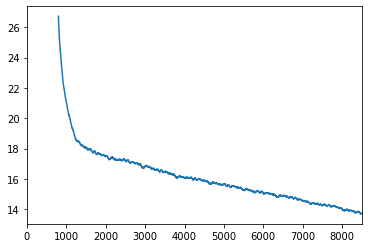

In [67]:
%matplotlib inline
df = pd.read_csv('pix2pixPlateGenLog.log')
df.rolling(window = 800)['G_loss'].mean().plot()

In [17]:
help(imageio.imwrite)

Help on function imwrite in module imageio.core.functions:

imwrite(uri, im, format=None, **kwargs)
    imwrite(uri, im, format=None, **kwargs)
    
    Write an image to the specified file.
    
    Parameters
    ----------
    uri : {str, pathlib.Path, file}
        The resource to write the image to, e.g. a filename, pathlib.Path
        or file object, see the docs for more info.
    im : numpy.ndarray
        The image data. Must be NxM, NxMx3 or NxMx4.
    format : str
        The format to use to read the file. By default imageio selects
        the appropriate for you based on the filename and its contents.
    kwargs : ...
        Further keyword arguments are passed to the writer. See :func:`.help`
        to see what arguments are available for a particular format.

